#  Zero-Noise Extrapolation (ZNE)

Implémenter expérimentalement la Zero-Noise Extrapolation (ZNE) de l'article de Temme-Bravyi-Gambetta, et vérifier numériquement que :

$$ E(\lambda) = E^* +a_1\lambda + a_2\lambda^2+\dots$$

et qu'une extrapolation de Richardson améliore l'estimation.

In [160]:
!pip install -q qiskit qiskit-aer qiskit-ibm-runtime pylatexenc

---

## Initialisation du Circuit

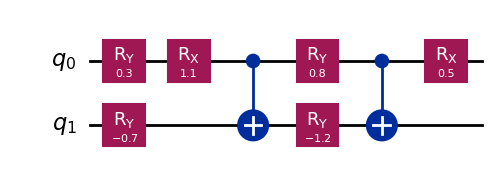

In [161]:
import qiskit

from qiskit import QuantumCircuit
import numpy as np

def initialize_circuit() -> QuantumCircuit:
  theta = [0.3, 1.1, -0.7, 0.8, -1.2, 0.5] # 6 angles, certain assez grand pour avoir de l'intrication et éviter d'avoir un cas trivial

  # création du circuit
  qc = QuantumCircuit(2)

  # application des portes
  qc.ry(theta[0], 0)
  qc.ry(theta[2], 1)

  qc.rx(theta[1], 0)

  qc.cx(0,1)

  qc.ry(theta[3], 0)
  qc.ry(theta[4], 1)

  qc.cx(0,1)

  qc.rx(theta[5], 0)
  return qc

qc = initialize_circuit()

# affiche notre circuit terminé
qc.draw(output="mpl", style="iqp")

### Pourquoi ce circuit est bon pour ZNE ?

- Les deux CNOT rendent le circuit très sensible au bruit dépolarisant.
- Il n’est pas symétrique trivialement donc l’observable ne va pas être 0 par accident.
- Assez long pour voir une erreur.
- Assez court pour rester dans le régime perturbatif.

Avec :

$$Ry(\theta) = exp \left({\theta \\ -i-Y \\ 2}\right)= \left({{cos(\theta/2) \quad -sin(\theta/2)}\\ {sin(\theta/2) \quad cos(\theta/2)}} \right)$$

---

## Observable

Nous allons mesurer $\langle Z_0 Z_1\rangle$, la corrélation,
car cette grandeur est sensible à l'intrication, facile à reconstruire à partir des counts, intéressant physiquement (corrélation).

En effet on a :
$$ \langle Z_0 Z_1\rangle = P(00) + P(11) - P(01) - P(10)$$

### Simulation du circuit

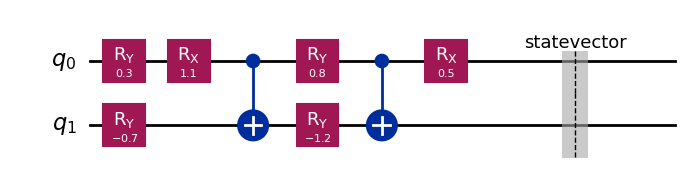

In [162]:
from qiskit_aer import AerSimulator
from qiskit import transpile

def save_statevector(qc:QuantumCircuit, shots:int) -> list:
  simulator = AerSimulator(method="statevector")

  qc_t = transpile(qc, simulator)
  job = simulator.run(qc_t, shots=shots)
  result = job.result()
  state = result.get_statevector()
  return state

shots = 10000

qc.save_statevector()
psi = save_statevector(qc, shots)

qc.draw(output="mpl", style="iqp")

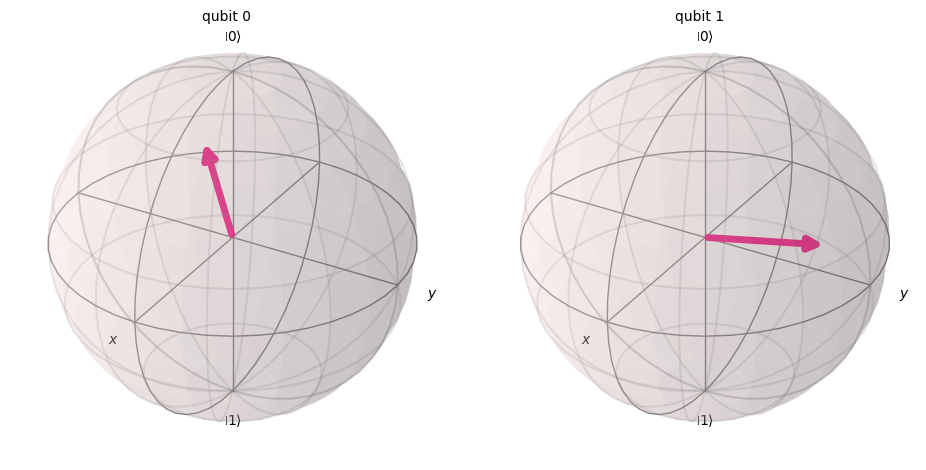

In [163]:
from qiskit.visualization import plot_bloch_multivector

plot_bloch_multivector(psi)

### calcul de la corrélation

$$\langle Z_0 Z_1\rangle = |C_{00}|^2 + |C_{1}|^2 - |C_{01}|^2 - |C_{10}|^2$$

In [164]:
def P(c_ij:float) -> float:
  return c_ij.conj() * c_ij

def compute_correlation(statevector:list) -> float:
  return (P(statevector[0]) + P(statevector[3]) - P(statevector[1]) - P(statevector[2])).real

correlation = compute_correlation(psi)
print("correlation :", correlation)

correlation : -0.6390459210354608


## Appliquer un bruit

In [165]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

def initialize_noise_model(p:float = 0.01) -> NoiseModel:
  noise_model = NoiseModel()

  error_1q = depolarizing_error(p, 1) # Bruit 1-qubit
  error_2q = depolarizing_error(p, 2) # Bruit 2-qubit

  # bruit 1q sur ['rx','ry'], bruit 2q sur ['cx']
  noise_model.add_all_qubit_quantum_error(error_1q, ['rx','ry'])
  noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
  return noise_model

def save_density_matrix(qc:QuantumCircuit, noise_model:NoiseModel, shots:int) -> list:
  simulator = AerSimulator(method="density_matrix", noise_model=noise_model) # on a besoin de density matrix car avec le bruit notre etat ne seras plus pure donc plus un state vector

  qc_t = transpile(qc, simulator)
  job = simulator.run(qc_t, shots=shots)
  result = job.result()
  density_matrix = result.data(0)['density_matrix']
  return density_matrix

def simulate_noise(p:float, shots:int) -> list:
  qc_noisy = initialize_circuit()
  noise_model = initialize_noise_model(p)

  qc_noisy.save_density_matrix()
  rho = save_density_matrix(qc_noisy, noise_model, shots)
  return rho

shots = 10000
p = 0.01

rho = simulate_noise(p, shots)

Maintenant la corrélation avec la matrice densité est :

$$\langle Z_0 Z_1\rangle = Tr[(Z\otimes Z)\rho]$$

In [167]:
def compute_correlation_density_matrix(rho:list) -> float:
  Z = np.array([[1, 0], [0, -1]], dtype = complex)
  ZZ = np.kron(Z, Z)
  return np.trace(ZZ @ np.array(rho)).real

correlation_noisy = compute_correlation_density_matrix(rho)
print(f"correlation_noisy with p={p} :", correlation_noisy)
print(f"error : {abs(correlation - correlation_noisy)}")

correlation_noisy with p=0.01 : -0.6035772637676394
error : 0.035468657267821335


On trouve une erreur assez faible, un resultat donc assez proche surement parce que p est petit.

### Erreur dû au bruit

$$E(p) = \text{Corrélation avec bruit}(p) - \text{Corrélation}$$

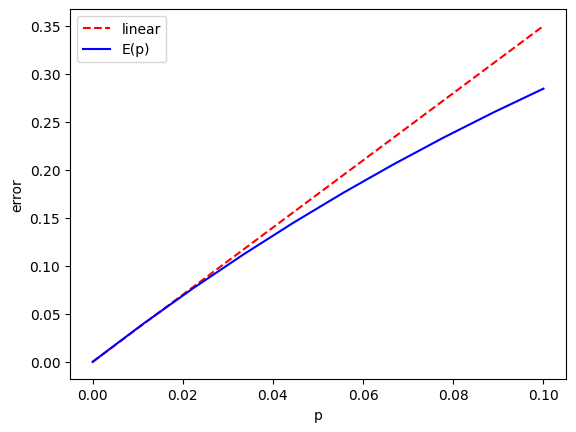

In [184]:
from matplotlib.lines import lineStyles
import matplotlib.pyplot as plt

shots = 10000
p_range = np.linspace(0, 0.1, 10)

correlation_noisy = []
for p in p_range :
  rho = simulate_noise(p, shots)
  correlation_noisy.append(compute_correlation_density_matrix(rho))

error = np.abs(np.array(correlation_noisy) - correlation)

plt.plot(p_range, p_range*3.5, color="red", label="linear", linestyle='--')
plt.plot(p_range, error, color="blue", label="E(p)")
plt.legend()
plt.xlabel("p")
plt.ylabel("error")
plt.show()

On voit que notre système peut être considéré comme perturbatife car pour petit p.

En effet en dessous de 0.02 notre courbe semble linéaire apres cette valeur la courbe dérive.

---

## Reference

- **Error Mitigation for Short-Depth Quantum Circuits**
Kristan Temme, Sergey Bravyi, and Jay M. Gambetta
*IBM T. J. Watson Research Center, Yorktown Heights, New York 10598, USA*
(Received 21 July 2017; published 3 November 2017)

- Yunos EL KADERI's course on **Quantum Computation and Error-Control Codes** (Master 2)